### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
rng = np.random.default_rng(0)

# Problem 1 [65 Marks]

You will be simulating the 10-armed bandit testbed.


### Single Bandit problem

The bandit problem should have $10$ arms. For each arm, the $q_{*}(a)$ value should be sampled from a Gaussian distribution with $0$ mean and unit variance . The rewards from arm $a$ should be sampled from a Gaussian distribution with mean $q_{}(a)$  and unit variance .


### Testbed

Generate 2000 different bandit problems. Use the sample average method with incremental implementation for learning the action values. Plot the learning curves for 1000 timesteps with the following algorithms:

- greedy
- $ϵ$-greedy
  - $ϵ$-0.1
  - $ϵ$-0.01

There are two learning curves for each algorithm:
- average reward vs time
- %  optimal actions vs time

You have to reproduce the following two curves:
1. Average rewards vs # of steps
2. % optimal action vs # of steps



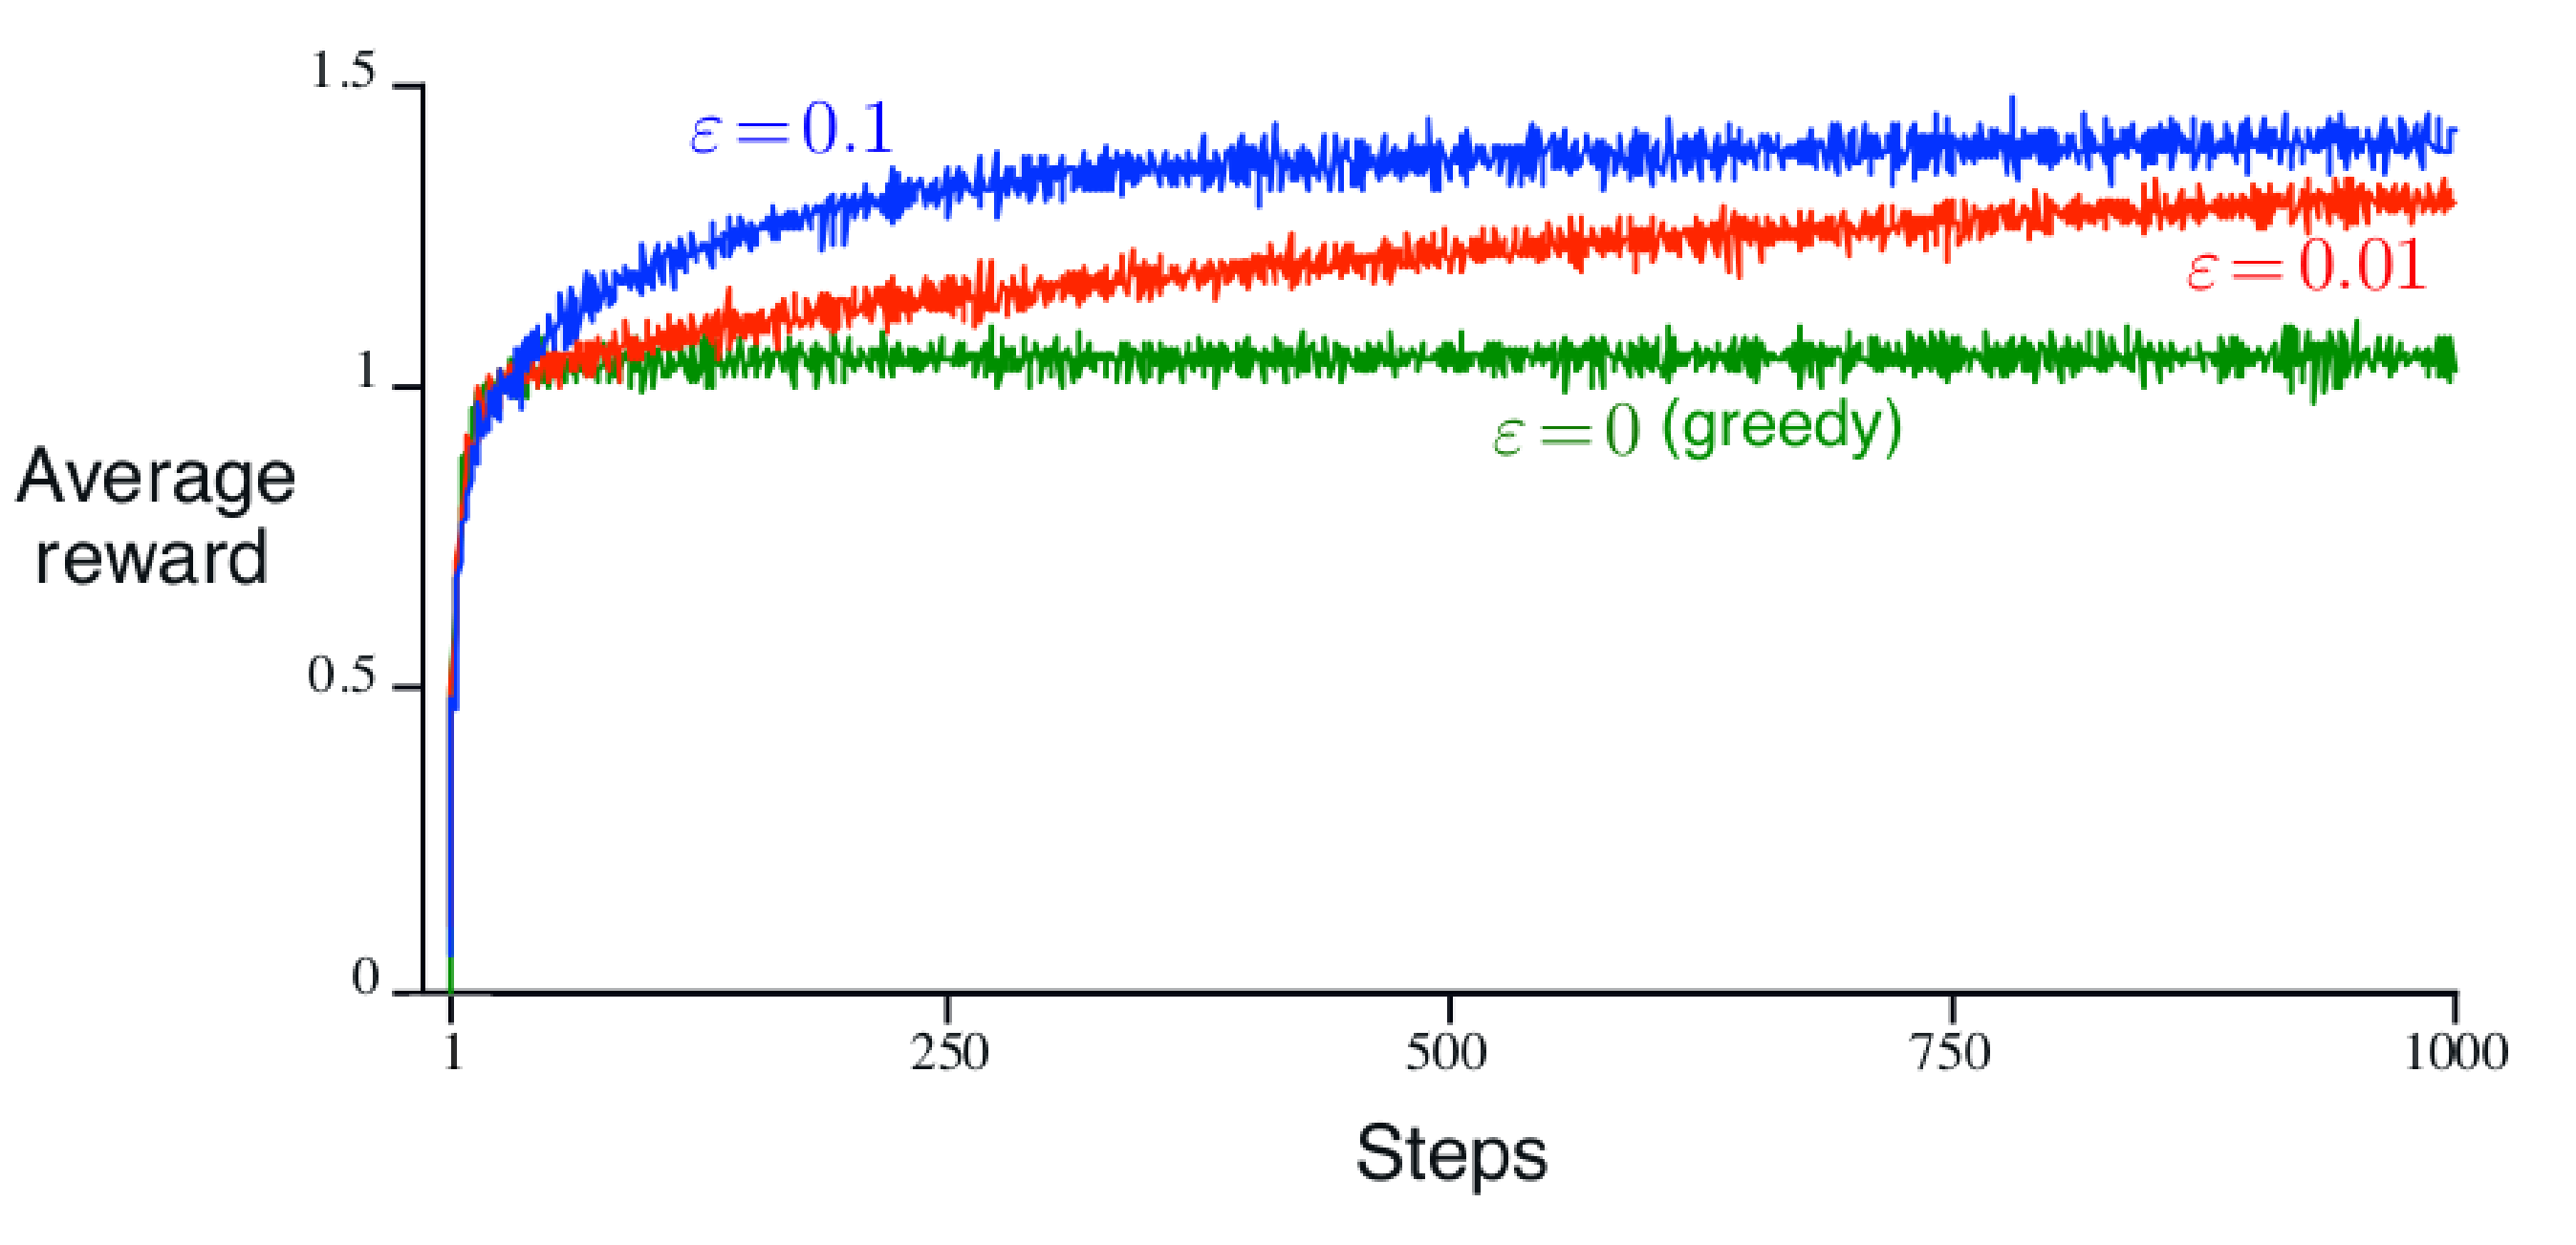

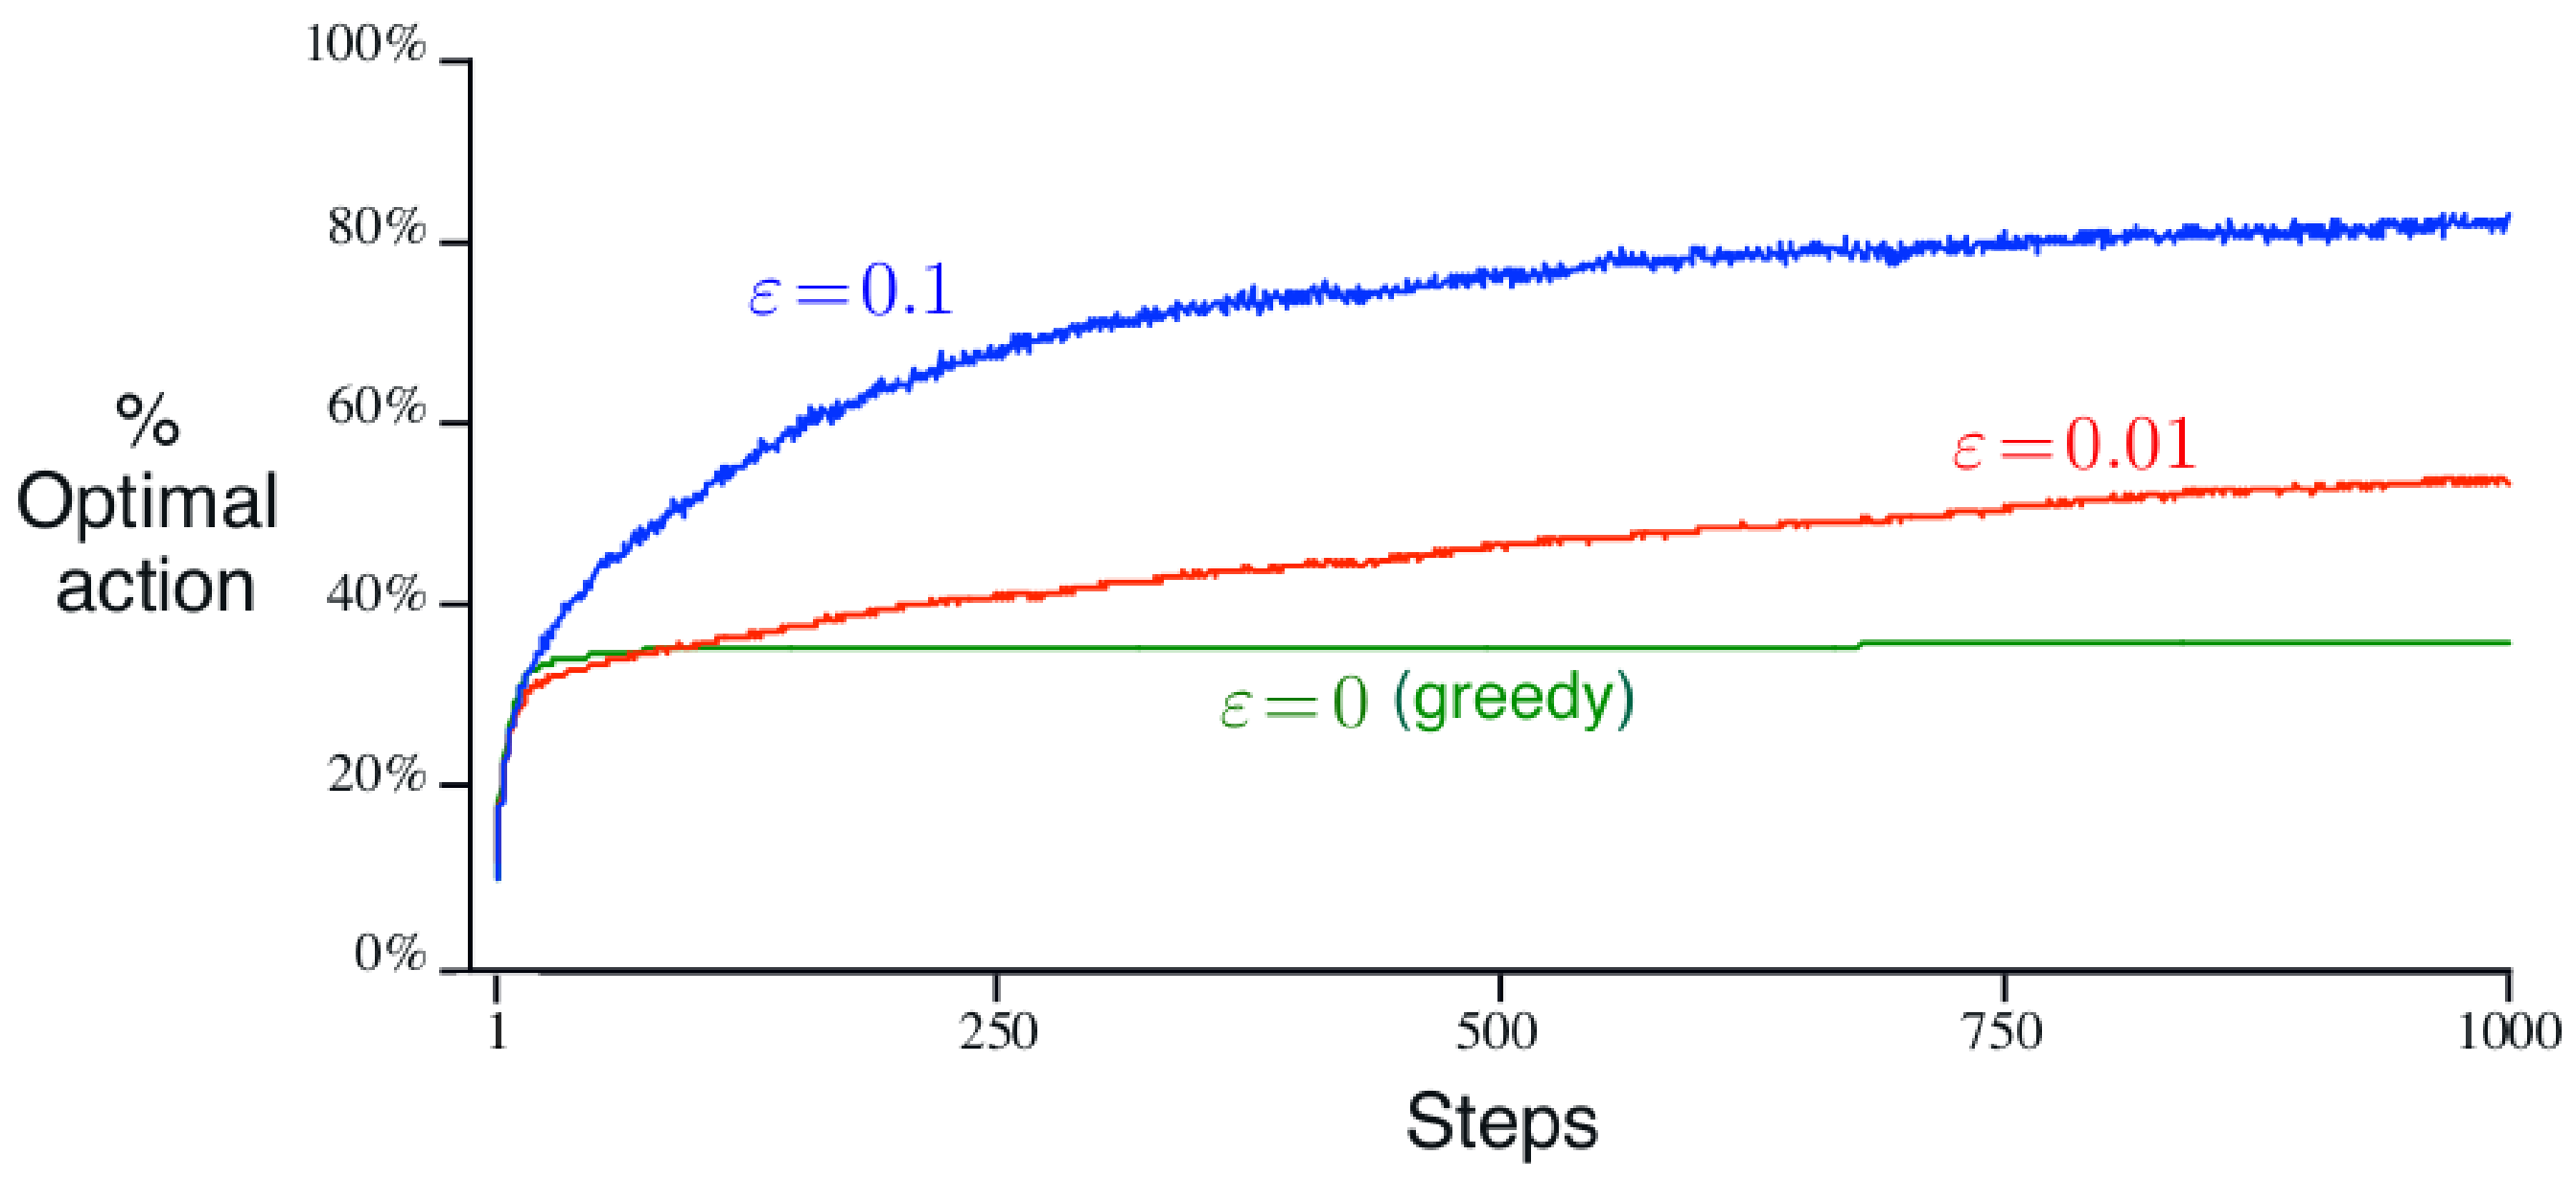

**Hint**: the averaging at each time step is done over all the 2000 bandit problems. For example, to
plot a single point $(t,r(t))$ in the "average reward plot", find the reward sampled from each of the 2000  bandits at time $t$ and compute their average. This value will be $r(t)$.

In [ ]:
# Simulation constants
NUM_BANDITS = 2000
TIME_STEPS = 1000
EPSILON_VALUES = [0, 0.01, 0.1]
UCB_C = 2

In [ ]:
class Bandit:
    """
    Multi-armed bandit class representing a single bandit with multiple arms.
    Each arm has a true value (q_true) and an estimated value (q_estimate).
    """
    def __init__(self, k_arm):
        """
        Initialize a k-armed bandit.

        Args:
            k_arm (int): Number of arms for the bandit
        """
        self.k = k_arm
        # True values for each arm (normally distributed)
        self.q_true = rng.normal(loc=0, scale=1, size=self.k)
        # Estimated values for each arm (initialized to 0)
        self.q_estimate = np.zeros(self.k)
        # Count of times each arm has been pulled
        self.action_count = np.zeros(self.k)
        # Record the best true Q
        self.best_q = np.max(self.q_true)

    def pull(self, action):
        """
        Pull an arm and get reward.

        Args:
            action (int): The arm to pull

        Returns:
            float: The reward (normally distributed around true value)
        """
        return rng.normal(loc=self.q_true[action], scale=1)

    def update(self, action, reward):
        """
        Update the estimated value for an arm based on received reward.

        Args:
            action (int): The arm that was pulled
            reward (float): The reward received
        """
        self.action_count[action] += 1
        # Incremental update formula
        self.q_estimate[action] += (reward - self.q_estimate[action]) / self.action_count[action]

In [ ]:
def run_bandit_simulation(strategy, param, num_arms):
    """
    Run a complete simulation of the multi-armed bandit problem.

    Args:
        strategy (function): Action selection strategy (epsilon-greedy or UCB)
        param (float): Parameter for the strategy (epsilon or c)
        num_arms (int): Number of arms for each bandit

    Returns:
        tuple: (average rewards, percentage of optimal actions)
    """
    # Initialize bandits
    bandits = [Bandit(k_arm=num_arms) for _ in range(NUM_BANDITS)]
    rewards = np.zeros(TIME_STEPS)
    optimal_actions = np.zeros(TIME_STEPS)

    # Run simulation
    for t in range(TIME_STEPS):
        total_reward = 0
        optimal_action_count = 0

        for bandit in bandits:
            # Select and execute action
            action = strategy(bandit, param)
            reward = bandit.pull(action)
            bandit.update(action, reward)

            # Track metrics
            total_reward += reward
            # Note: Multiple arms might have the same optimal value
            if bandit.q_true[action] == bandit.best_q:
                optimal_action_count += 1

        # Calculate averages
        rewards[t] = total_reward / NUM_BANDITS
        optimal_actions[t] = (optimal_action_count / NUM_BANDITS) * 100

    return rewards, optimal_actions

In [ ]:
def plot_bandit_results(rewards_dict, optimal_actions_dict, title_suffix=""):
    """
    Plot the results of bandit simulations.

    Args:
        rewards_dict (dict): Dictionary of rewards for each strategy
        optimal_actions_dict (dict): Dictionary of optimal action percentages
        title_suffix (str): Additional text for plot titles
    """
    plt.figure(figsize=(12, 5))

    # Plot average rewards
    plt.subplot(1, 2, 1)
    for label, rewards in rewards_dict.items():
        plt.plot(rewards, label=label)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title(f"Average Reward vs. Steps{title_suffix}")
    plt.legend()

    # Plot optimal action percentages
    plt.subplot(1, 2, 2)
    for label, optimal_actions in optimal_actions_dict.items():
        plt.plot(optimal_actions, label=label)
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.title(f"% Optimal Action vs. Steps{title_suffix}")
    plt.legend()

    plt.tight_layout()
    plt.show()

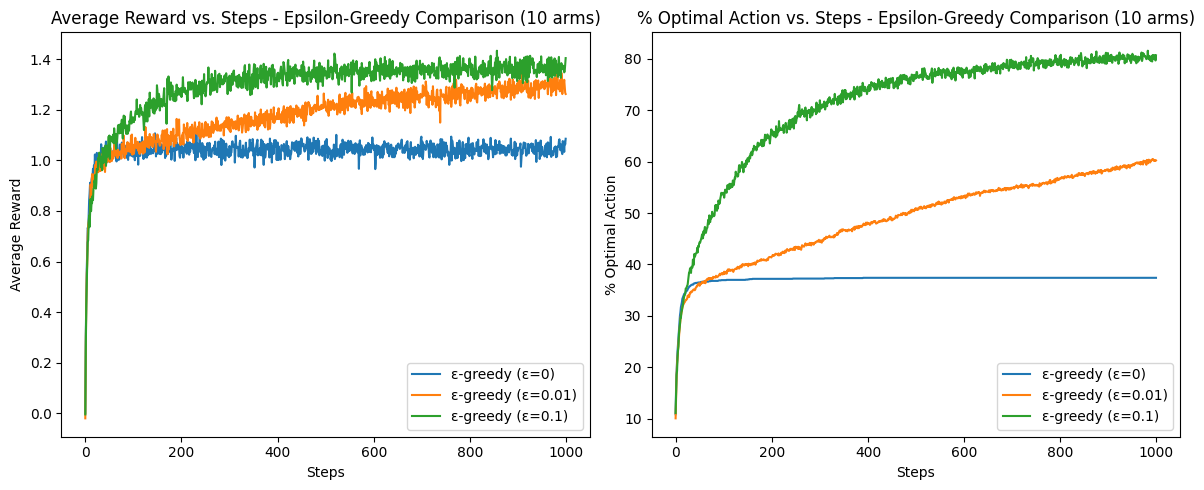

In [ ]:
# write your code here for problem-1

def epsilon_greedy(bandit, epsilon):
    """
    Epsilon-greedy action selection strategy.

    Args:
        bandit (Bandit): The bandit to select action from
        epsilon (float): Exploration probability

    Returns:
        int: Selected action
    """
    if rng.random() < epsilon:
        # Explore: choose random action
        return rng.integers(bandit.k)
    # Exploit: choose best known action
    return np.argmax(bandit.q_estimate)

def run_epsilon_greedy_comparison(num_arms):
    """
    Run and plot comparison of different epsilon values for epsilon-greedy strategy.

    Args:
        num_arms (int): Number of arms for each bandit

    Returns:
        tuple: Results for epsilon=0.1 (used in UCB comparison)
    """
    # Run simulations for different epsilon values
    average_rewards = {epsilon: np.zeros(TIME_STEPS) for epsilon in EPSILON_VALUES}
    optimal_action_percentages = {epsilon: np.zeros(TIME_STEPS) for epsilon in EPSILON_VALUES}

    for epsilon in EPSILON_VALUES:
        rewards, optimal_actions = run_bandit_simulation(epsilon_greedy, epsilon, num_arms)
        average_rewards[epsilon] = rewards
        optimal_action_percentages[epsilon] = optimal_actions

    # Prepare and plot results
    epsilon_rewards = {f'ε-greedy (ε={epsilon})': average_rewards[epsilon]
                      for epsilon in EPSILON_VALUES}
    epsilon_optimal = {f'ε-greedy (ε={epsilon})': optimal_action_percentages[epsilon]
                      for epsilon in EPSILON_VALUES}

    plot_bandit_results(epsilon_rewards, epsilon_optimal,
                       f" - Epsilon-Greedy Comparison ({num_arms} arms)")

    return average_rewards[0.1], optimal_action_percentages[0.1]


rewards_epsilon_10, optimal_actions_epsilon_10 = run_epsilon_greedy_comparison(num_arms=10)

### Observations from Problem-1

#### Average Reward vs. Steps Analysis

1. **ε = 0 (Pure Exploitation)**
   - *Initial Advantage*: Shows the steepest initial reward increase in the first few steps, demonstrating the short-term benefit of immediate exploitation
   - *Premature Convergence*: Quickly plateaus at ~1.0 reward, substantially below optimal performance
   - *Fundamental Limitation*: Becomes permanently trapped exploiting whichever action had the highest initial sample rewards, regardless of true expected values, resulting in the lowest asymptotic performance

2. **ε = 0.01 (Limited Exploration)**
   - *Measured Growth*: Demonstrates steady improvement throughout all 1000 timesteps without plateauing
   - *Long-Term Potential*: By step 1000, narrows the gap with ε = 0.1 to approximately 0.1 reward units, suggesting continued convergence
   - *Efficiency Trade-off*: Sacrifices short-term performance for reliable long-term improvement

3. **ε = 0.1 (Higher Exploration)**
   - *Superior Performance*: Maintains the highest average reward throughout most of the experiment (~1.4 by step 1000)
   - *Optimal Balance*: Allocates sufficient actions to exploration (10%) while maximizing exploitation (90%) of discovered high-value actions

#### % Optimal Action vs. Steps Analysis

1. **ε = 0 (Pure Exploitation)**
   - *Initial Sampling Dependency*: Optimal action selection rate (~33%) directly reflects the chance of initially selecting the optimal arm and receiving a favorable reward estimate
   - *Fixed Performance*: After initial learning, flatlines without improvement, indicating complete failure to correct initial suboptimal selections
   - *Sampling Limitation*: Without exploration, relies entirely on fortunate initial sampling to find optimal actions

2. **ε = 0.01 (Limited Exploration)**
   - *Consistent Growth*: Shows steady increase in optimal action selection throughout all 1000 timesteps, reaching ~60%
   - *Uncompleted Learning*: Upward trajectory continues at experiment end, suggesting potential for further improvement with additional timesteps
   - *Exploration Impact*: Each step provides a 1% chance of exploring and discovering the optimal action, gradually improving overall performance

3. **ε = 0.1 (Higher Exploration)**
   - *Rapid Convergence*: Achieves approximately 80% optimal action selection by step 1000
   - *Theoretical Ceiling*: Approaching its asymptotic maximum of 91% (limited by the 10% exploration rate)
   - *Efficient Discovery*: Higher exploration rate significantly accelerates identification of the optimal action
   - *Strategic Balance*: The 10% exploration rate proves to be better for this specific 10-arm 1000-timestep testing environment

# Problem 2 [35 Marks]

Run the UCB algorithm on the ten-armed testbed. Plot the learning curve for UCB and compare it with $\epsilon$-greedy for $\epsilon = 0.1$. Reproduce the following learning curves averaged over 2000  bandits for 1000 timesteps:

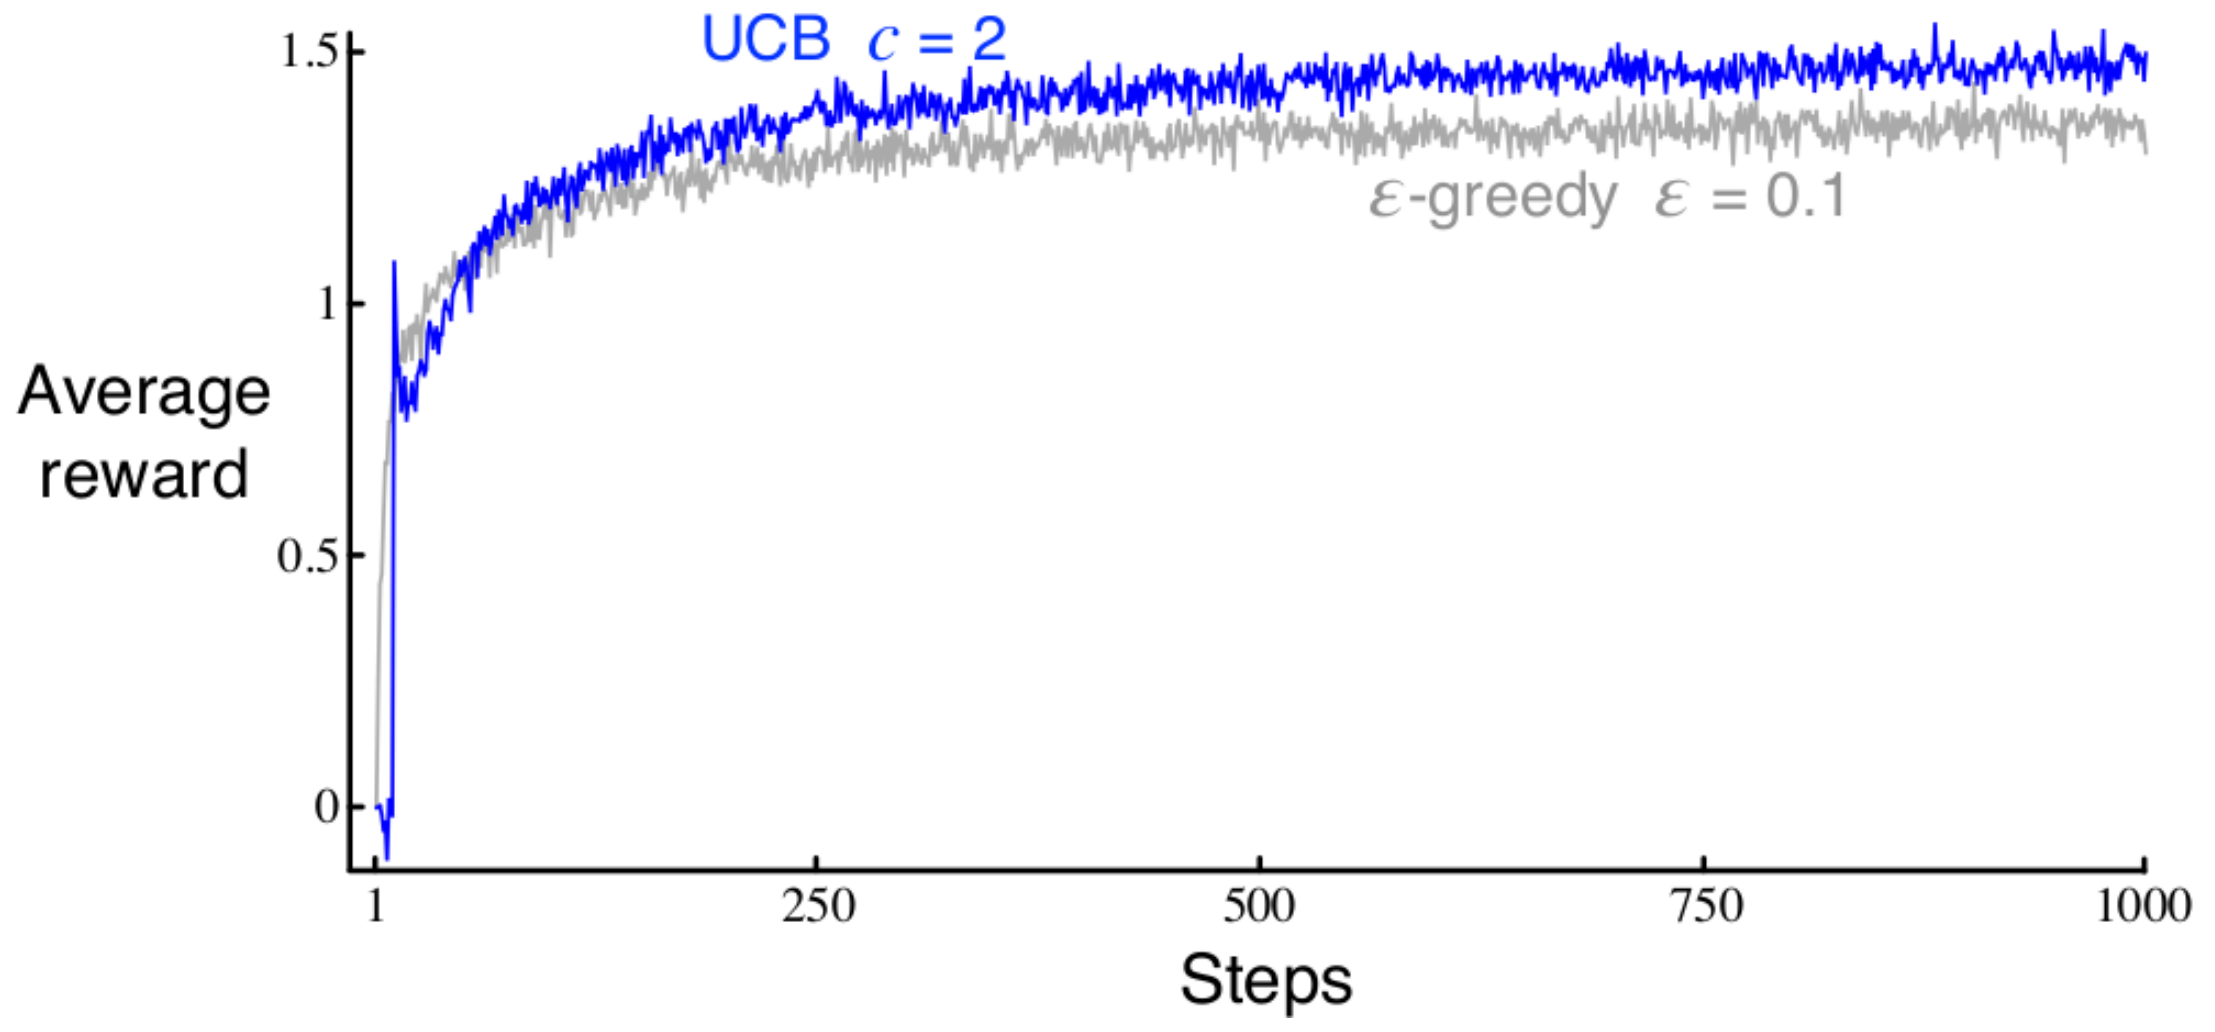

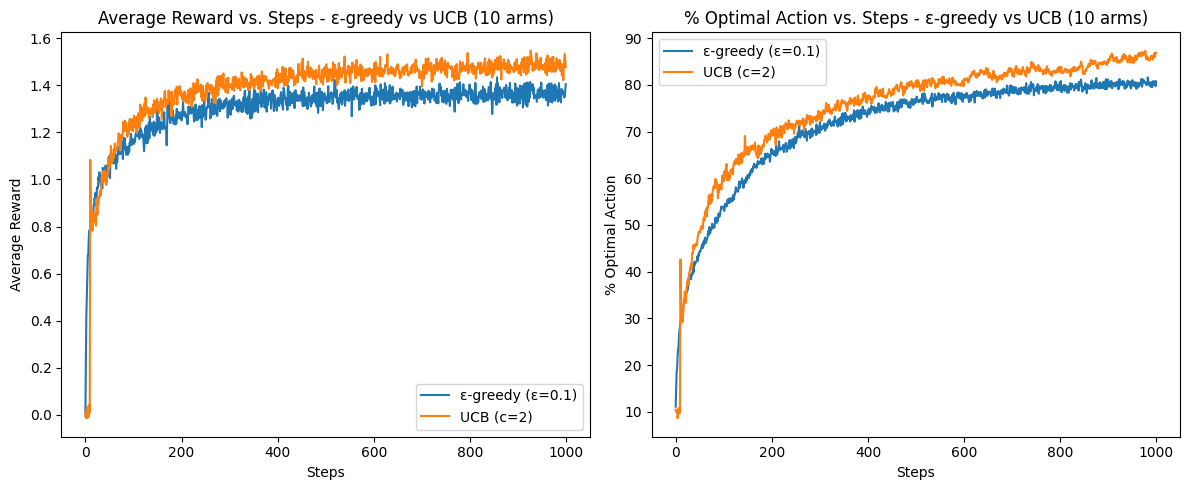

In [ ]:
# write your code here for problem-2

def ucb(bandit, c):
    """
    Upper Confidence Bound (UCB) action selection strategy.

    Args:
        bandit (Bandit): The bandit to select action from
        c (float): Exploration-vs-Exploitation parameter

    Returns:
        int: Selected action
    """
    arms_not_pulled_once = np.where(bandit.action_count == 0)[0]
    if len(arms_not_pulled_once) > 0:
      # Return the first arm that hasn't been pulled
      return arms_not_pulled_once[0]
    else:
      n = bandit.action_count.sum()
      ucb_values = bandit.q_estimate + c * np.sqrt(np.log(n) / bandit.action_count)
      return np.argmax(ucb_values)


def compare_ucb_epsilon_greedy(rewards_epsilon, optimal_actions_epsilon, num_arms):
    """
    Run and plot comparison between UCB and epsilon-greedy strategies.

    Args:
        rewards_epsilon (array): Rewards from epsilon-greedy (ε=0.1)
        optimal_actions_epsilon (array): Optimal actions from epsilon-greedy (ε=0.1)
        num_arms (int): Number of arms for each bandit
    """
    # Run UCB simulation
    rewards_ucb, optimal_actions_ucb = run_bandit_simulation(ucb, UCB_C, num_arms)

    # Prepare and plot comparison
    comparison_rewards = {
        'ε-greedy (ε=0.1)': rewards_epsilon,
        'UCB (c=2)': rewards_ucb
    }
    comparison_optimal = {
        'ε-greedy (ε=0.1)': optimal_actions_epsilon,
        'UCB (c=2)': optimal_actions_ucb
    }

    plot_bandit_results(comparison_rewards, comparison_optimal,
                       f" - ε-greedy vs UCB ({num_arms} arms)")

compare_ucb_epsilon_greedy(rewards_epsilon_10, optimal_actions_epsilon_10, num_arms=10)

### Observations from problem-2

#### Initial Exploration Phase
- During the first 10 timesteps, the UCB algorithm methodically explores all 10 actions exactly once. This should happens because mathematically, for any unselected action, $N_t(a) = 0$, resulting in an infinite upper confidence bound, guaranteeing each action will be selected once.
- After all actions have been tried once (t=10), UCB has one sample to estimate the value of each arm with equal uncertainty across all actions.
- At t=11, UCB selects the action with the highest observed reward from the initial exploration, which might be the optimal arm and will likely give it an similarly large reward, creating the performance spike visible in both plots.
- Subsequently, the confidence bounds adjust: the uncertainty around the chosen arm narrows, while it increases for the other arms, causing UCB to explore other promising actions, explaining the temporary decrease in performance following the spike.

#### Left Plot: Average Reward vs. Steps

1. **UCB (c=2)**:
   - Achieves consistently higher average rewards than ε-greedy after the initial exploration phase
   - Converges more rapidly to near-optimal performance due to its adaptive exploration strategy

2. **ε-greedy (ε=0.1)**:
   - Improves more slowly and stabilizes at a lower average reward
   - The constant exploration rate means it continues selecting random actions 10% of the time, even after identifying high-value arms
   - This uniform random exploration fails to distinguish between slightly suboptimal and extremely poor actions, wasting exploration opportunities

#### Right Plot: % Optimal Action vs. Steps

1. **UCB (c=2)**:
   - More rapidly reaches around 90% selection of the optimal action
   - The adaptive confidence bounds allow UCB to focus exploration on genuinely uncertain but potentially optimal actions
   - As uncertainty about the optimal arm decreases, UCB increasingly favors it over alternatives
   - The remaining ~10% non-optimal selections represent UCB's ongoing but increasingly targeted exploration

2. **ε-greedy (ε=0.1)**:
   - The percentage of optimal actions plateaus around 80% within 1000 timesteps
   - Theoretically, its long-run optimal selection rate would asymptotically approach 91% (as ε=0.1 means 10% random exploration)
   - The fixed exploration strategy prevents ε-greedy from fully capitalizing on its knowledge of the optimal arm
   - Unlike UCB, ε-greedy's exploration does not become more focused over time

# Bonus Problem [10 Marks]

Solve problems 1 and 2 for $10,000$ arms.

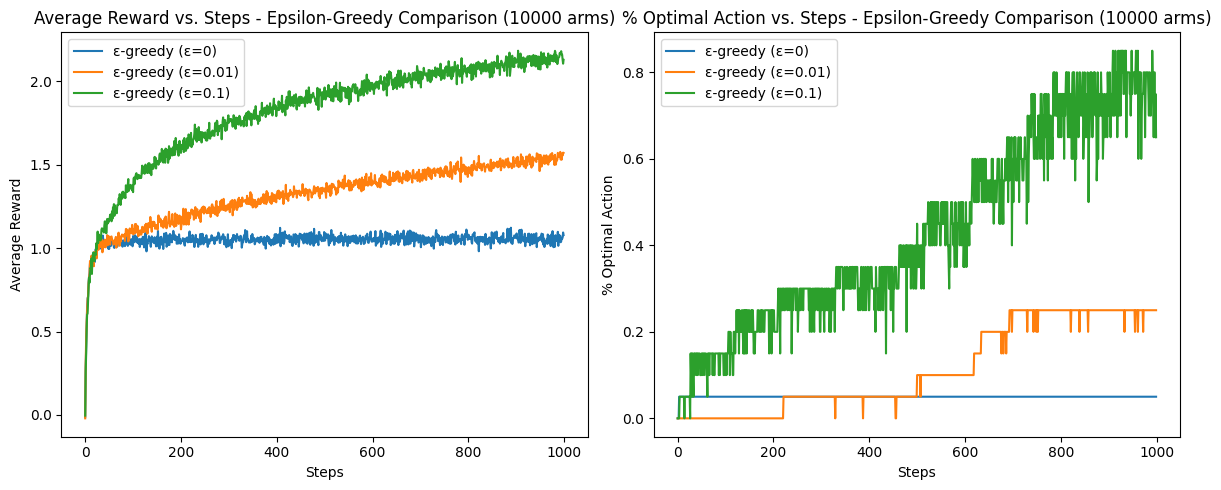

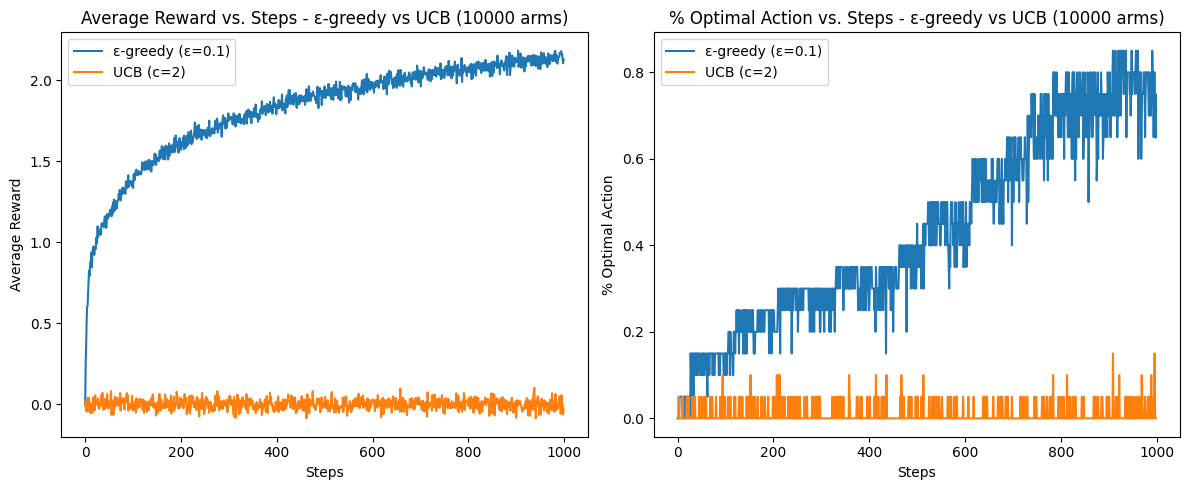

In [ ]:
# write your code here for the bonus problem

rewards_epsilon_10k, optimal_actions_epsilon_10k = run_epsilon_greedy_comparison(num_arms=10_000)
compare_ucb_epsilon_greedy(rewards_epsilon_10k, optimal_actions_epsilon_10k, num_arms=10_000)

## Observations for Bonus Problem

### **First Set of Plots: ε-Greedy Comparison (ε = 0, 0.01, 0.1)**

#### **Average Reward vs. Steps**
- The performance differences between exploration rates become dramatically magnified in the 10,000-arm setting compared to the original 10-arm problem.
- **ε = 0 (Pure exploitation)**: Performs extremely poorly, plateauing at a very low reward level. Without exploration, the agent cannot discover actions with higher expected rewards.
- **ε = 0.01 (Limited exploration)**: Shows improvement over time but remains significantly suboptimal. The infrequent exploration provides too few opportunities to discover high-value arms in such a vast action space.
- **ε = 0.1 (Higher exploration)**: Substantially outperforms the other rates, showing consistent reward growth throughout the experiment. This higher exploration rate proves crucial in a 10,000-arm environment, as it enables sufficient sampling to discover increasingly valuable arms among the thousands of options.

#### **% Optimal Action vs. Steps**
- Finding the optimal action among 10,000 possibilities presents a dramatically greater challenge than in the 10-arm scenario, requiring far more extensive exploration.
- **ε = 0**: Remains essentially flat at near-zero optimal action selection (below 0.1%), demonstrating a complete inability to discover the optimal arm.
- **ε = 0.01**: Displays a distinctive step-like pattern with wide horizontal plateaus between infrequent upward jumps, reaching only about 0.3% optimal action selection. Each upward step represents a rare successful discovery of the optimal arm during exploration.
- **ε = 0.1**: Exhibits a similar step pattern but with narrower plateaus and more frequent transitions, reflecting its higher exploration rate. Each plateau shows a period of exploiting the currently best-known arm, downward dips occur when exploration selects suboptimal arms, and upward jumps mark successful discoveries of optimal arms. This more dynamic pattern enables better overall performance despite the vast action space.

### **Second Set of Plots: ε-Greedy (ε = 0.1) vs. UCB (c = 2)**

#### **Average Reward vs. Steps**
- **UCB (c = 2)**: Exhibits near-zero average reward throughout the experiment.
- **ε-Greedy (ε = 0.1)**: Shows steady and significant reward improvement over time, clearly outperforming UCB in this large-scale problem.

#### **% Optimal Action vs. Steps**
- **UCB (c = 2)**: Essentially flatlines at 0%, with minor oscillations but no meaningful improvement trend, failing to identify the optimal action within the given timeframe.
- **ε-Greedy (ε = 0.1)**: Demonstrates gradual but consistent improvement in optimal action selection, establishing a clear advantage over UCB.

#### **Algorithm Performance Analysis**

1. **UCB's Failure in Large Action Spaces**:
   - UCB's core principle of trying each action at least once becomes its critical weakness in this setting. With 10,000 arms but only 1,000 timesteps, UCB remains permanently stuck in its initial exploration phase.
   - The algorithm never accumulates enough samples of any single arm to begin meaningful exploitation, as it prioritizes trying untested arms with infinite upper confidence bounds.
   - This fundamental mismatch between problem scale and algorithm design renders UCB completely ineffective when actions vastly outnumber available timesteps.

2. **ε-Greedy's Scalability Advantage**:
   - Unlike UCB, ε-greedy doesn't require systematic exploration of all arms before exploitation begins.
   - With ε = 0.1, the algorithm dedicates 90% of its actions to exploiting the best-known arm while still allocating 10% to random exploration.
   - This balanced approach allows ε-greedy to simultaneously exploit promising arms while continuing to discover potentially better options.
   - The algorithm's simplicity becomes its strength in large-scale problems, as it doesn't collapse under the burden of exhaustive exploration.